In [26]:
import pandas as pd

#df = pd.read_csv('../data/museum_data_mean_target_encoding.csv')
df_train = pd.read_csv("data/museum_data_mean_target_encoding_train.csv")
df_train.drop(['Unnamed: 0', 'Object Begin Date'], axis=1, inplace=True)

df_test = pd.read_csv("data/museum_data_mean_target_encoding_test.csv")
df_test.drop(['Unnamed: 0', 'Object Begin Date'], axis=1, inplace=True)
df_train

,Historical Period,height,diam,width,depth,num_period,medium_num,classif_num,culture_num
0,Antiquity,7.1,-1.0,10.8,-1.0,4.0,3.046062,2.533376,2.136866
1,Antiquity,-1.0,3.7,-1.0,-1.0,4.0,3.046062,3.998735,4.000000
2,Antiquity,2.9,-1.0,9.2,-1.0,4.0,3.875496,3.993417,3.905965
3,Antiquity,2.7,-1.0,2.2,-1.0,4.0,3.046062,2.533376,3.301802
4,Antiquity,-1.0,-1.0,-1.0,-1.0,4.0,3.119048,2.533376,3.841270
...,...,...,...,...,...,...,...,...,...
40175,Modern Times,24.8,-1.0,-1.0,-1.0,2.0,1.982170,2.056168,2.136866
40176,Modern Times,2.5,-1.0,3.8,5.1,2.0,1.702391,1.991786,1.815829
40177,Modern Times,48.3,-1.0,-1.0,-1.0,2.0,2.076923,2.056168,2.136866
40178,Modern Times,3.2,-1.0,4.4,-1.0,2.0,2.182008,1.991786,1.815829


In [32]:
hello = pd.read_csv("data/met_dataset.csv")
hello.head()

,Object ID,Object ID.1,Medium,Classification,Dimensions,Culture,Object Begin Date,Object End Date
0,0,1,Gold,NaN,Dimensions unavailable,NaN,1853,1853
1,1,2,Gold,NaN,Dimensions unavailable,NaN,1901,1901
2,2,3,Gold,NaN,Diam. 11/16 in. (1.7 cm),NaN,1909,1927
3,3,4,Gold,NaN,Diam. 11/16 in. (1.7 cm),NaN,1909,1927
4,4,5,Gold,NaN,Diam. 11/16 in. (1.7 cm),NaN,1909,1927


In [31]:
len(hello["Culture"].unique())

7181

In [24]:
df_train.iloc[20000,:]

Historical Period    Contemporary Era
height                          241.9
diam                               -1
width                           117.5
depth                              -1
num_period                          1
medium_num                    1.72804
classif_num                   2.15319
culture_num                   2.13687
Name: 20000, dtype: object

In [22]:
map_period = {"Contemporary Era":1., "Modern Times": 2., "Middle Ages":3., "Antiquity":4.}

### Preprocessing

#### Get X and y

In [23]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

periods_train = np.array(df_train["Historical Period"]).reshape(-1, 1)

ohe = OneHotEncoder(sparse=False)
ohe.fit(periods_train)
y_ohe_train = ohe.transform(periods_train)

periods_test = np.array(df_test["Historical Period"]).reshape(-1, 1)
y_ohe_test = ohe.transform(periods_test)
y_ohe_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
# key: name of the class; item: index of the column in y
dico_period_ohe = {"Modern Times":3, "Contemporary Era":1, "Antiquity":0, "Middle Ages":2}

In [5]:
import numpy as np
y_train = np.array(df_train["num_period"])
y_train

array([4., 4., 4., ..., 2., 2., 2.])

In [6]:
X_train = np.array(df_train.drop(columns=["Historical Period", "num_period"]))
X_train.shape

(40180, 7)

In [7]:
y_test = np.array(df_test["num_period"])
X_test = np.array(df_test.drop(columns=["Historical Period", "num_period"]))

#### Rescaling the features

medium_num, culture_num and classif_num are bounded between 1 and 4 by construction (fine).


Let's transform the features related to dimensions: height, width, depth and diam. It doesn't really make sense (from a physical point of view) to normalize them to zero mean and unit variance. Instead, let's rescale them so that they are between 0 and 1:

In [8]:
X_train[0,:]

array([ 7.1       , -1.        , 10.8       , -1.        ,  3.04606152,
        2.53337623,  2.13686557])

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train[:,:4])
dims_train_minmax = scaler.transform(X_train[:,:4])

In [10]:
# check
print(np.min(dims_train_minmax, axis=0), np.max(dims_train_minmax, axis=0))

[0. 0. 0. 0.] [1. 1. 1. 1.]


In [11]:
X_train[:,:4] = dims_train_minmax
print(X_train[0,:])

[0.00339836 0.         0.00640886 0.         3.04606152 2.53337623
 2.13686557]


In [12]:
# apply the same transformation on testing set
dims_test_minmax = scaler.transform(X_test[:,:4])
X_test[:,:4] = dims_test_minmax
X_test[0,:]

array([0.        , 0.00655793, 0.        , 0.        , 2.93310463,
       3.05988515, 2.96666667])

### Machine Learning models

#### Baseline Multinomial Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state=0, multi_class="multinomial")
logit.fit(X_train, y_train)

/Users/terencengo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:

def plot_confusion_matrix(model, X_test, y_test, model_name=""):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    preds = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_mat, cmap="Blues",
    annot=True, xticklabels=map_period.keys(),
    yticklabels=map_period.keys(),
    )
    plt.title("Confusion matrix of {}".format(model_name))
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

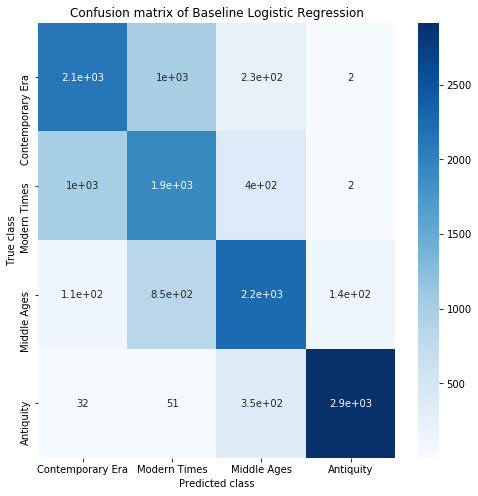

In [15]:
plot_confusion_matrix(logit, X_test, y_test, model_name="Baseline Logistic Regression")

In [25]:
#from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

accuracy_score(y_test, logit.predict(X_test))

0.6860256793072559

#### Tuned Multinomial Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_logit_params = {"C": np.linspace(1e-4,0.1,10)} # quite computationnally expensive

logit_base = LogisticRegression(penalty="elasticnet", l1_ratio=0.5, solver="saga", random_state=0, multi_class="multinomial")
clf = GridSearchCV(logit_base, grid_logit_params, cv=5, scoring="accuracy")
clf.fit(X_train, y_train)

In [40]:
grid_logit_results = pd.DataFrame(data=clf.cv_results_)
grid_logit_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.239001,0.065407,0.000856,0.000069,0.0001,{'C': 0.0001},0.490169,0.489049,0.481707,0.478472,0.491289,0.486137,0.005092,10
1,0.198858,0.009559,0.000880,0.000004,0.0112,{'C': 0.0112},0.672847,0.668243,0.675958,0.665879,0.675834,0.671752,0.004059,9
2,0.196750,0.008008,0.000921,0.000068,0.0223,{'C': 0.0223},0.685416,0.678820,0.688527,0.678198,0.677700,0.681732,0.004404,8
3,0.207664,0.018009,0.001050,0.000175,0.0334,{'C': 0.033400000000000006},0.686287,0.678447,0.688776,0.678571,0.685789,0.683574,0.004258,7
4,0.227582,0.007403,0.001057,0.000051,0.0445,{'C': 0.044500000000000005},0.686536,0.679069,0.687904,0.679567,0.687656,0.684146,0.003972,6
5,0.255526,0.022393,0.001026,0.000137,0.0556,{'C': 0.055600000000000004},0.687282,0.679318,0.688029,0.679567,0.687904,0.684420,0.004073,5
6,0.292053,0.016302,0.001071,0.000086,0.0667,{'C': 0.06670000000000001},0.687158,0.679816,0.687780,0.679567,0.688153,0.684495,0.003936,4
7,0.358323,0.019783,0.001038,0.000045,0.0778,{'C': 0.07780000000000001},0.687158,0.679567,0.688402,0.679069,0.688527,0.684545,0.004297,3
8,0.403196,0.021846,0.001184,0.000282,0.0889,{'C': 0.0889},0.687033,0.679940,0.688527,0.679069,0.689522,0.684818,0.004419,2
9,0.426948,0.024982,0.000993,0.000126,0.1,{'C': 0.1},0.687033,0.680314,0.688651,0.678945,0.689647,0.684918,0.004419,1


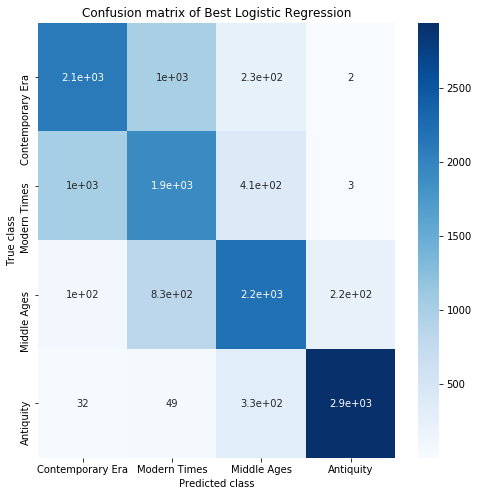

In [42]:
logit_best = clf.best_estimator_
plot_confusion_matrix(logit_best, X_test, y_test, model_name="Best Logistic Regression")

In [43]:
accuracy_score(y_test, logit_best.predict(X_test))

0.6828904150492684

#### Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

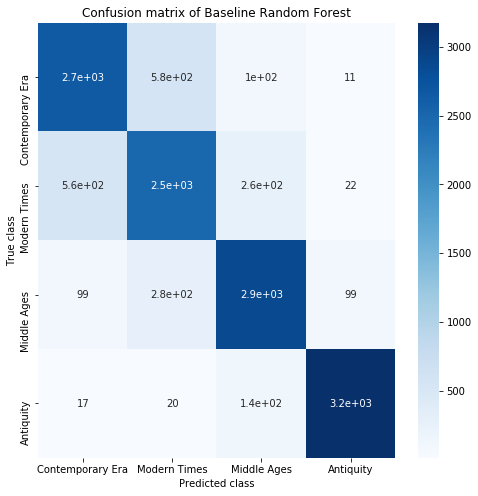

In [51]:
plot_confusion_matrix(rfc, X_test, y_test, model_name="Baseline Random Forest")

In [52]:
accuracy_score(y_test, rfc.predict(X_test))

0.8369662585846521

#### Tuned Random Forest

In [53]:
grid_rfc_params = {"max_depth": range(20,60,10)} # quite computationnally expensive

rfc_base = RandomForestClassifier(n_estimators=100, random_state=0)
clf_rfc = GridSearchCV(rfc_base, grid_rfc_params, cv=5, scoring="accuracy")
clf_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [54]:
grid_rfc_results = pd.DataFrame(data=clf_rfc.cv_results_)
grid_rfc_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.106230,0.155338,0.133751,0.003573,20,{'max_depth': 20},0.837979,0.836610,0.839721,0.840841,0.833375,0.837705,0.002605,1
1,2.173057,0.029409,0.141267,0.001538,30,{'max_depth': 30},0.832753,0.831882,0.834868,0.836486,0.828273,0.832852,0.002800,4
2,2.248317,0.036355,0.153841,0.017438,40,{'max_depth': 40},0.834868,0.833873,0.834619,0.837606,0.829393,0.834072,0.002659,2
3,2.374790,0.050772,0.153899,0.004062,50,{'max_depth': 50},0.834370,0.833499,0.834121,0.837606,0.829268,0.833773,0.002666,3


Not impact on the perfs:

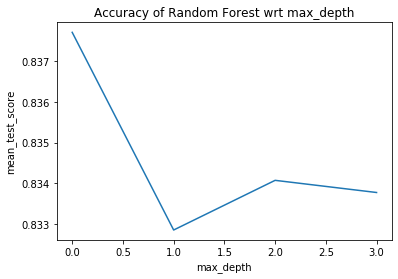

In [75]:
import matplotlib.pyplot as plt
grid_rfc_results["mean_test_score"].plot()
plt.xlabel("max_depth")
plt.ylabel("mean_test_score")
plt.title("Accuracy of Random Forest wrt max_depth")
plt.show()

### Support Vector Machines

In [83]:
from sklearn.svm import SVC

svc = SVC(C=10, kernel="rbf", gamma="scale", random_state=0)
svc.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

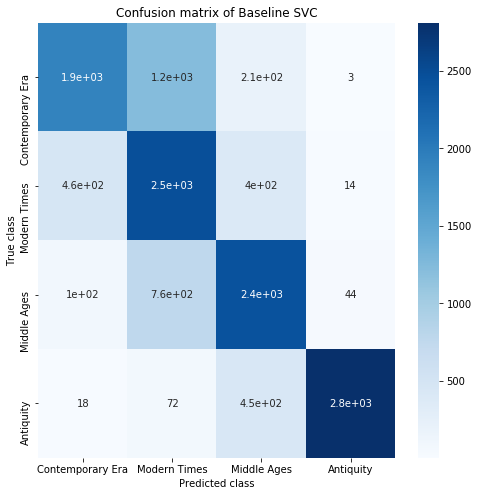

In [84]:
plot_confusion_matrix(svc, X_test, y_test, model_name="Baseline SVC")

In [85]:
accuracy_score(y_test, svc.predict(X_test))

0.7194684980591222